In [1]:
%load_ext autoreload
%autoreload 3 --print

In [34]:
from argparse import Namespace
import joblib as jl

from kpsn_test.routines.util import load_cfg, save_results, update, find_file

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

from kpsn.util import keypt_io
from kpsn_test import visualize as viz


import numpy as np
from kpsn.models.morph import affine_mode as afm
from kpsn.models.morph import linear_skeletal as ls
from kpsn.util import skeleton, alignment, logging, keypt_io
from kpsn_test import visualize as viz
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt
import seaborn as sns
import jax.tree_util as pt

In [61]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
plot_dir = '../../plots/notebook/blscale_err_incr'

plt.style.use("vscode_dark")
sns.set_context('paper')

age_pal_type = viz.defaults.autumn_pal
clr = Namespace(bg_dot = '.4')

### Setup

In [6]:
args = Namespace(
    results_fmt = '../../results/lra/blscale_gmm-l1lock_morph-l0/{}.jl',
    output_fmt = '/tmp/{}.png',
    savefig_cfg = None,
    path = (),
)

In [7]:
if len(args.path) == 1:
    override_paths = None
    fallback_fmt = args.path[0]
else:
    override_paths = {
        args.path[2*i]: args.path[2*i + 1]
        for i in range(len(args.path) // 2)}
    fallback_fmt = None

load = lambda key: jl.load(find_file(
    key, args.results_fmt, override_paths, fallback_fmt))


dataset = load('dataset')
init = load('init')
fit = load('fit')
print("Loaded data.")

results = dict(
    dataset = dataset,
    init = init,
    fit = fit)

savefig_cfg = update(dict(
    dpi = 300
    ), load_cfg(args.savefig_cfg))
savefig = lambda fmt, fig: save_results(
    args.output_fmt, fmt,
    lambda path: fig.savefig(path, **savefig_cfg))

Loaded data.


In [63]:
ref_sess = '3wk_m0'
meta = dataset['metadata']
slices = meta['session_slice']
feats = {s: dataset['keypts'][slc] for s, slc in meta['session_slice'].items()}

to_kpt, _ = alignment.gen_kpt_func(dataset['keypts'], origin_keypt = 'hips')

age_pal = viz.defaults.age_pal(meta['tgt_age'], func = age_pal_type)

In [47]:
def reconst_feat_with_params(params):
    pose = afm.inverse_transform(
        params, feats[ref_sess], meta['session_ix'][ref_sess])
    copied_poses = jnp.concatenate([pose for _ in range(params.N)])
    return afm.transform(
        params, copied_poses, dataset['subject_ids'])

ini_reconst = reconst_feat_with_params(init.morph)
fit_reconst = reconst_feat_with_params(fit['fit_params'].morph)

In [68]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
all_pcs = pca.fit_transform(dataset['keypts'])
pcs = {s: all_pcs[slc] for s, slc in meta['session_slice'].items()}

ini_all_pcs = pca.fit_transform(ini_reconst)
fit_all_pcs = pca.fit_transform(fit_reconst)

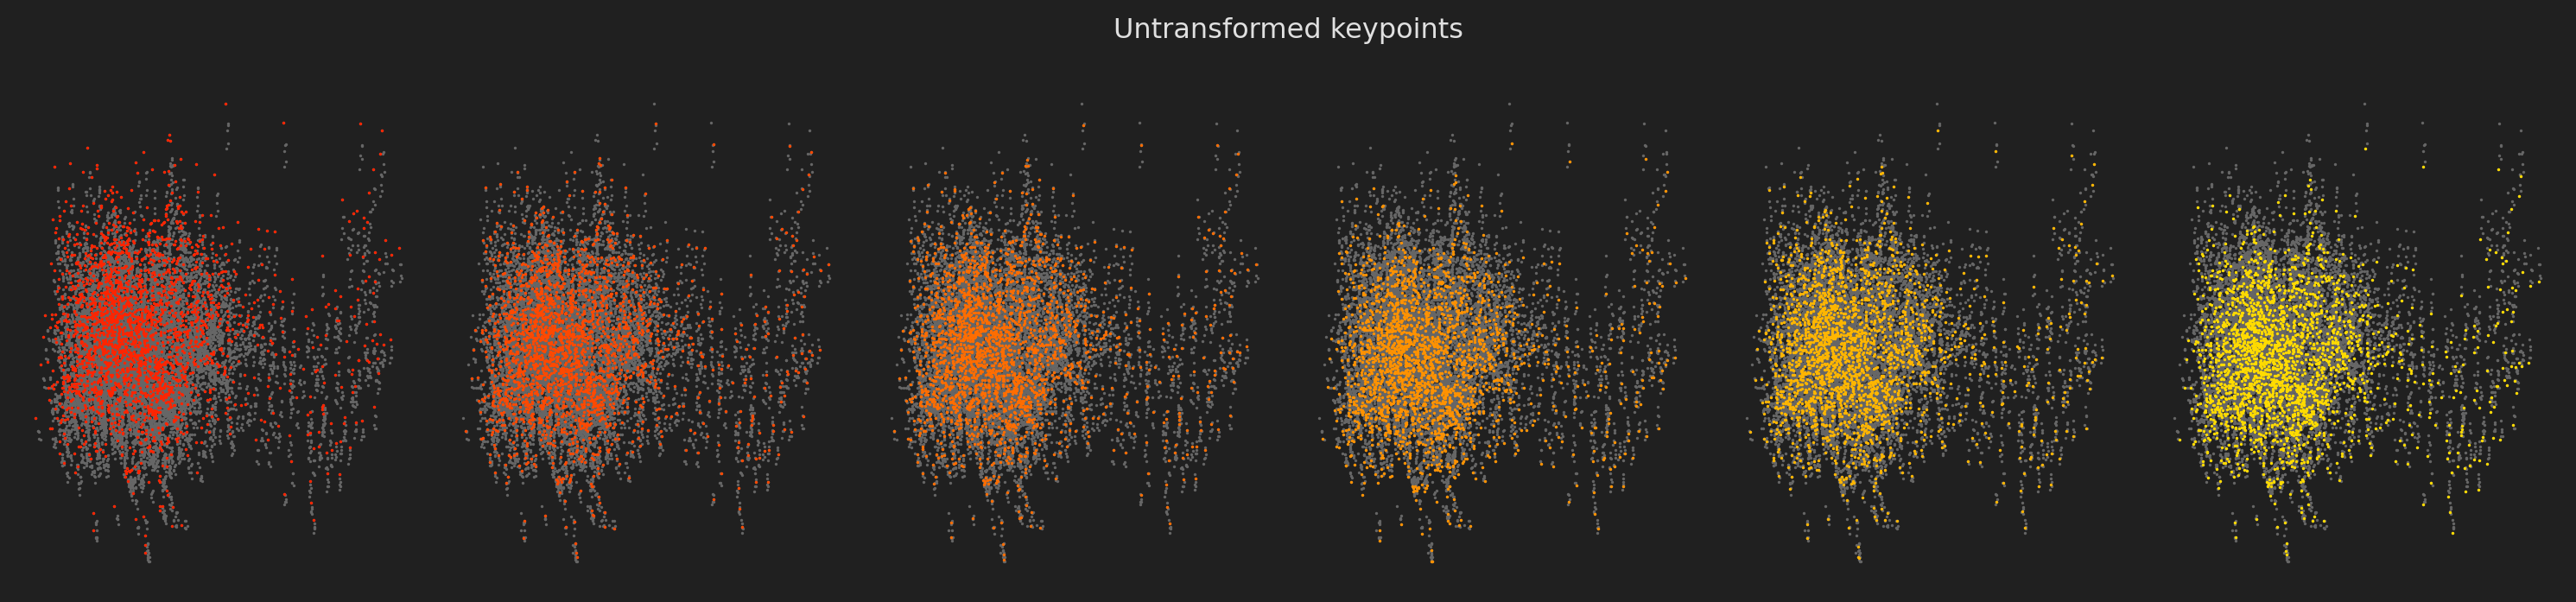

In [70]:
xaxis, yaxis = 0, 6

age_pal = viz.defaults.age_pal(meta['tgt_age'], func = viz.defaults.autumn_pal)
fig, axes, ax_grid = viz.struct.flat_grid(len(pcs), n_col = 6, ax_size = (2.5, 3.5), return_grid = True)


    
for ax, sess in zip(axes, pcs):
    ax.scatter(
        all_pcs[:, xaxis], all_pcs[:, yaxis],
        s = 1.5, marker = 'o', color = clr.bg_dot, lw = 0, rasterized = True)
    
    ax.scatter(
        pcs[sess][:, xaxis], pcs[sess][:, yaxis],
        s = 1.5, marker = 'o', lw = 0,
        color = age_pal[meta['tgt_age'][sess]], rasterized = True)
    
    ax.set_axis_off()

fig.suptitle("Untransformed keypoints")
fig.tight_layout()

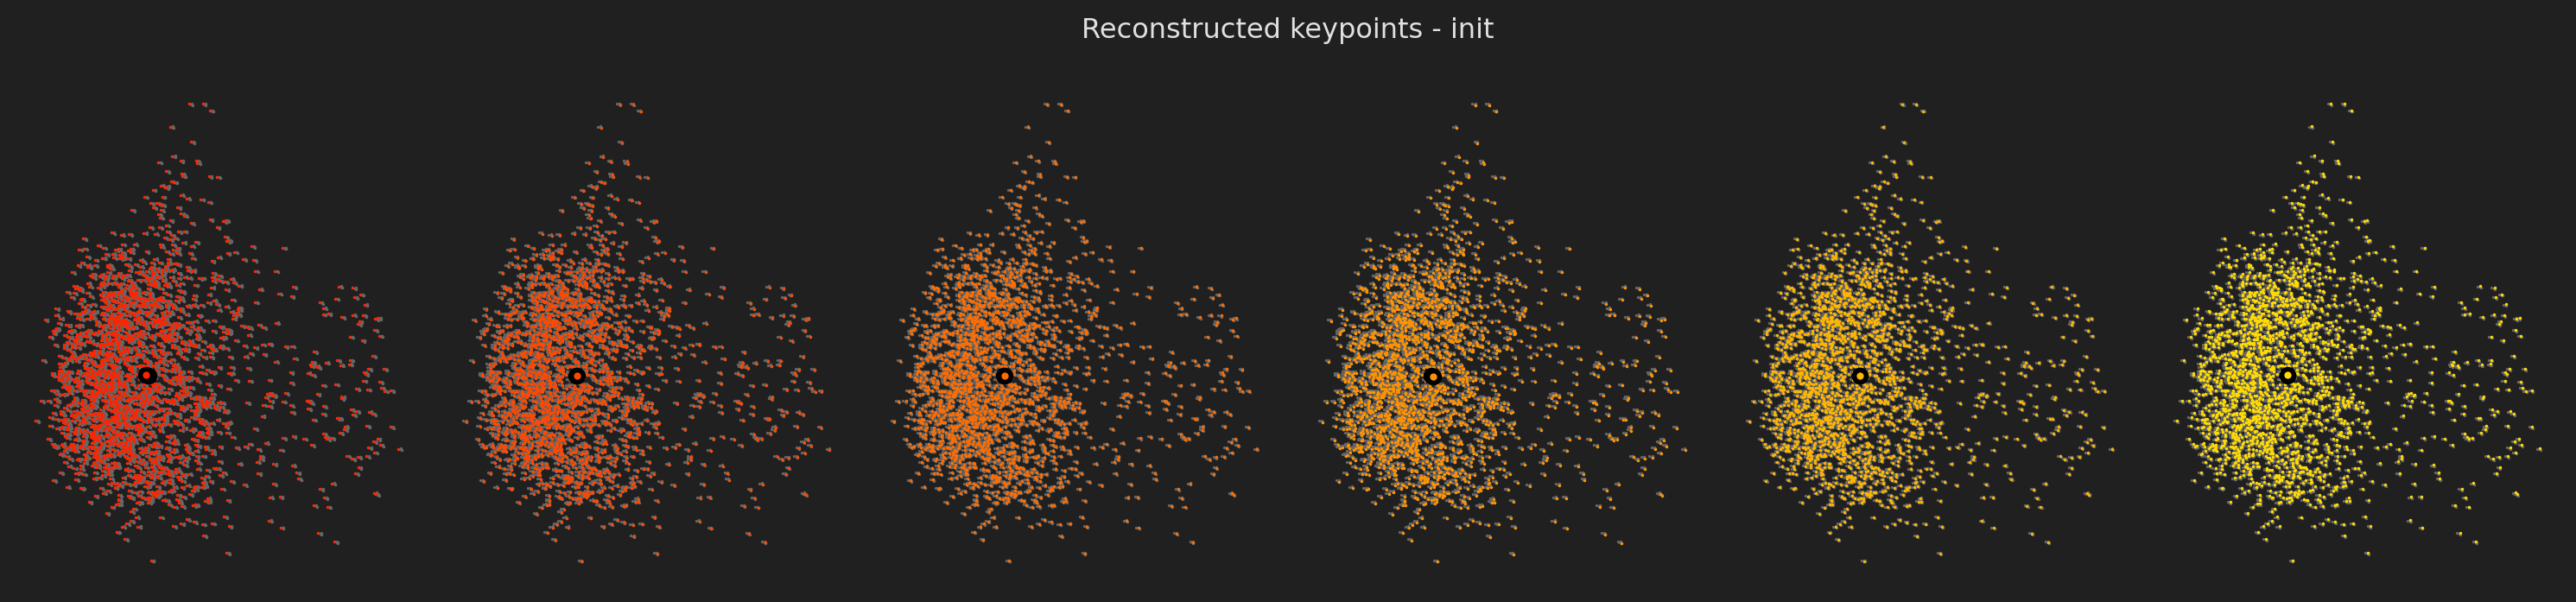

In [87]:
xaxis, yaxis = 0, 1

age_pal = viz.defaults.age_pal(meta['tgt_age'], func = viz.defaults.autumn_pal)
fig, axes, ax_grid = viz.struct.flat_grid(len(pcs), n_col = 6, ax_size = (2.5, 3.5), return_grid = True)


    
for ax, sess in zip(axes, pcs):
    ax.scatter(
        ini_all_pcs[:, xaxis], ini_all_pcs[:, yaxis],
        s = 1.5, marker = 'o', color = clr.bg_dot, lw = 0, rasterized = True, zorder = 1)
    
    sess_data = ini_all_pcs[slices[sess]]
    tgt_clr = age_pal[meta['tgt_age'][sess]]
    ax.scatter(
        sess_data[:, xaxis], sess_data[:, yaxis],
        s = 1.5, marker = 'o', lw = 0,
        color = tgt_clr, rasterized = True, zorder = 1)
    
    ax.plot(ini_all_pcs.mean(axis = 0)[[xaxis]], ini_all_pcs.mean(axis = 0)[[yaxis]],
        'o', color = 'w', mec = 'k', mew = 2, ms = 5, zorder = 4)
    
    ax.plot(sess_data.mean(axis = 0)[[xaxis]], sess_data.mean(axis = 0)[[yaxis]],
        'o', color = tgt_clr, mec = 'k', mew = 2, ms = 5, zorder = 4)
    
    
    
    ax.set_axis_off()

fig.suptitle("Reconstructed keypoints - init")
fig.tight_layout()

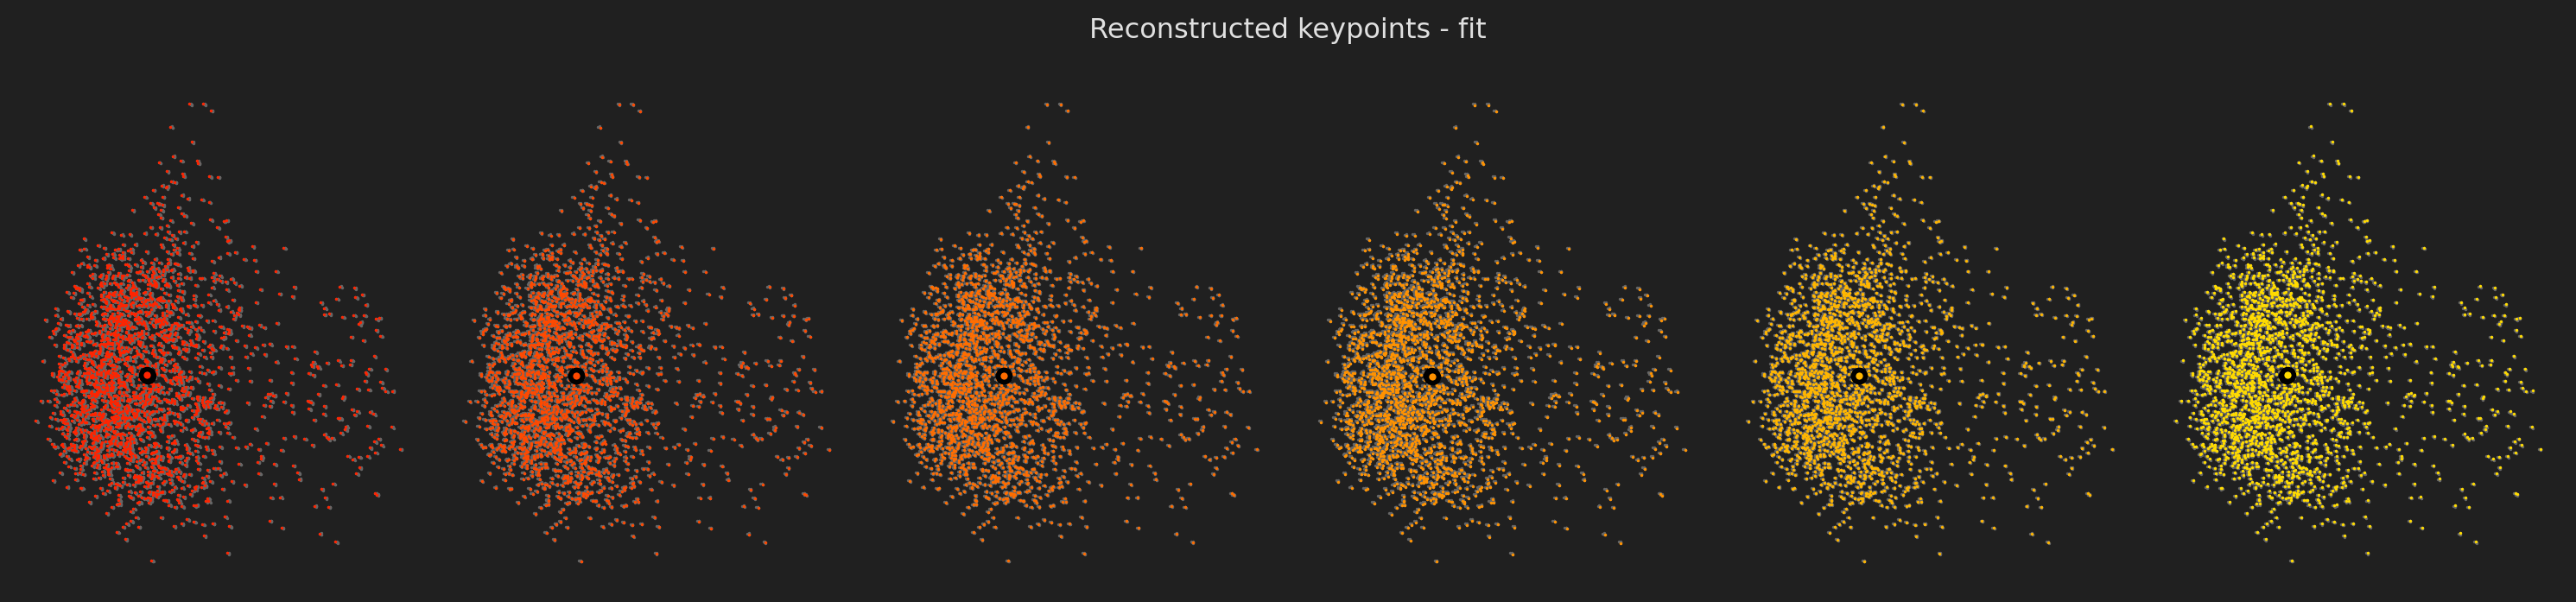

In [89]:
xaxis, yaxis = 0, 1

age_pal = viz.defaults.age_pal(meta['tgt_age'], func = viz.defaults.autumn_pal)
fig, axes, ax_grid = viz.struct.flat_grid(len(pcs), n_col = 6, ax_size = (2.5, 3.5), return_grid = True)


    
for ax, sess in zip(axes, pcs):
    ax.scatter(
        fit_all_pcs[:, xaxis], fit_all_pcs[:, yaxis],
        s = 1.5, marker = 'o', color = clr.bg_dot, lw = 0, rasterized = True, zorder = 1)
    
    sess_data = fit_all_pcs[slices[sess]]
    tgt_clr = age_pal[meta['tgt_age'][sess]]
    ax.scatter(
        sess_data[:, xaxis], sess_data[:, yaxis],
        s = 1.5, marker = 'o', lw = 0,
        color = tgt_clr, rasterized = True, zorder = 1)
    
    ax.plot(fit_all_pcs.mean(axis = 0)[[xaxis]], fit_all_pcs.mean(axis = 0)[[yaxis]],
        'o', color = 'w', mec = 'k', mew = 2, ms = 5, zorder = 4)
    
    ax.plot(sess_data.mean(axis = 0)[[xaxis]], sess_data.mean(axis = 0)[[yaxis]],
        'o', color = tgt_clr, mec = 'k', mew = 2, ms = 5, zorder = 4)
    
    ax.set_axis_off()


fig.suptitle("Reconstructed keypoints - fit")
fig.tight_layout()